In [1]:
import pandas as pd
import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt

In [2]:
# define constants
# output parameters
y_names = ['energy_high', 'energy_low']

# input parameters
# x_names = [c for c in df.columns if c not in y_names]
x_names = ['iload_ratio', 'rgoff', 'rgon', 't_dead', 'vsup_ratio', 'I_DSS', 'R_DS_on', 'R_G']

x_names_transform = ['C_ISS', 'C_OSS', 'C_RSS', 'Q_G', 'Q_GD', 'Q_GS']

# seed for replication
seed = 11

In [3]:
# loading data
transistor_names = ['GS66516T', 'GS66502B', 'GS66508T', 'GS66504B', 'GS66506T']
df_raw = pd.concat([pd.read_csv(f'./data/{name}_test.csv', sep=';')[x_names + x_names_transform + y_names] for name in transistor_names[:-1]], axis=0)

# filter data for energies higher than 10nJ and smaller than 500uJ
df = df_raw[(df_raw.energy_high < 500e-6) & (df_raw.energy_high > 10e-9) & (df_raw.energy_low < 500e-6) & (df_raw.energy_low > 10e-9)].dropna()

In [4]:
# create scaler and scale data, take the log of the data to assume a gaussian curve for one side shifted data -> better learning with gaussian curve because same shape like weight function
x_scaler = MinMaxScaler()
_ = x_scaler.fit(np.concatenate([df[x_names].values, np.log10(df[x_names_transform].values)], axis=1))
# x_scaled = x_scaler.fit_transform(df[x_names].values)
y_scaler = MinMaxScaler()
_ = y_scaler.fit(np.log10(df[y_names].values))
# y_scaled = y_scaler.fit_transform(np.log10(df[y_names].values))

In [5]:
# split data in train and test data and save as df 
# x_train, x_test, y_train, y_test = train_test_split(x_scaled, y_scaled, test_size=0.1, random_state=seed)

# df_x_test = pd.DataFrame(x_scaler.inverse_transform(x_test), columns=x_names)
# df_y_test = pd.DataFrame(10**y_scaler.inverse_transform(y_test), columns=y_names)
# df_x_train = pd.DataFrame(x_scaler.inverse_transform(x_train), columns=x_names)
# df_y_train = pd.DataFrame(10**y_scaler.inverse_transform(y_train), columns=y_names)

df_train = df.sample(n=len(df), ignore_index=True)
df_x_train = df_train[x_names + x_names_transform]
df_y_train = df_train[y_names]

x_train = x_scaler.transform(np.concatenate([df_x_train[x_names].values, np.log10(df_x_train[x_names_transform].values)], axis=1))
y_train = y_scaler.transform(np.log10(df_y_train.values))

df_test_raw = pd.read_csv(f'./data/{transistor_names[-1]}_test.csv', sep=';')[x_names + x_names_transform + y_names]
df_test = df_test_raw[(df_test_raw.energy_high < 300e-6) & (df_test_raw.energy_high > 50e-9) & (df_test_raw.energy_low < 300e-6) & (df_test_raw.energy_low > 50e-9)].dropna()
df_x_test = df_test[x_names + x_names_transform]
df_y_test = df_test[y_names]

In [6]:
# create net and set hyper parameters
mlp = MLPRegressor(hidden_layer_sizes=(64, 128, 64, 32), max_iter=1000, alpha=0.0001, solver='adam', activation='relu',
                    random_state=seed, batch_size=32, tol=1e-6, n_iter_no_change=100, early_stopping=True, verbose= False)

# train neural net
_ = mlp.fit(x_train, y_train)

In [7]:

# write function to put in real values 
def predict(df:pd.DataFrame):
    x_scaled_pred = x_scaler.transform(np.concatenate([df[x_names].values, np.log10(df[x_names_transform].values)], axis=1))
    y_scaled_pred = mlp.predict(x_scaled_pred)
    y = 10**y_scaler.inverse_transform(y_scaled_pred)
    return pd.DataFrame(y, columns=y_names)

In [8]:
# predict solution
df_y_pred = predict(df_x_test)

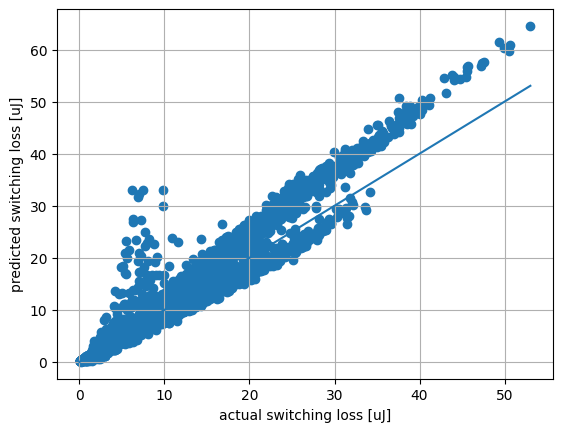

In [9]:

# plot prediction
# plt.scatter(np.log10(y_scaler.inverse_transform(y_test)*1e6), np.log10(y_scaler.inverse_transform(y_pred)*1e6))
plt.scatter(df_y_test[y_names[0]] * 1e6, df_y_pred[y_names[0]] * 1e6)
plt.plot(np.linspace(0, max(df_y_test[y_names[0]]*1e6), 10),np.linspace(0, max(df_y_test[y_names[0]]*1e6), 10))
plt.xlabel('actual switching loss [uJ]')
plt.ylabel('predicted switching loss [uJ]')
plt.grid()
plt.show()

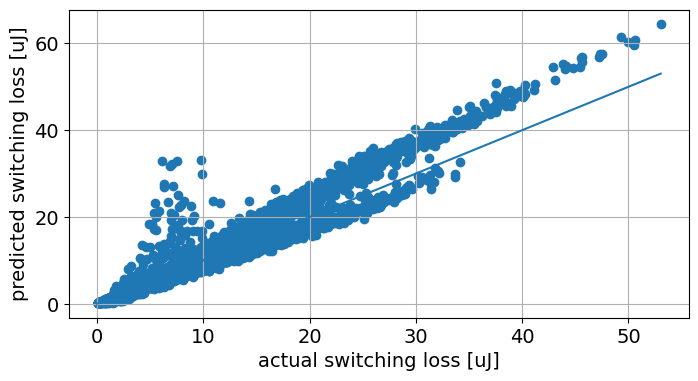

In [10]:
# Plot prediction
plt.figure(figsize=(8, 4))  # Set the figure size (width, height) in inches

plt.scatter(df_y_test[y_names[0]] * 1e6, df_y_pred[y_names[0]] * 1e6)
plt.plot(np.linspace(0, max(df_y_test[y_names[0]]*1e6), 10), np.linspace(0, max(df_y_test[y_names[0]]*1e6), 10))
plt.xlabel('actual switching loss [uJ]', fontsize=14)  # Adjust font size
plt.ylabel('predicted switching loss [uJ]', fontsize=14)  # Adjust font size
plt.grid()

# Adjust tick label size
plt.gca().tick_params(axis='both', which='major', labelsize=14)

plt.show()


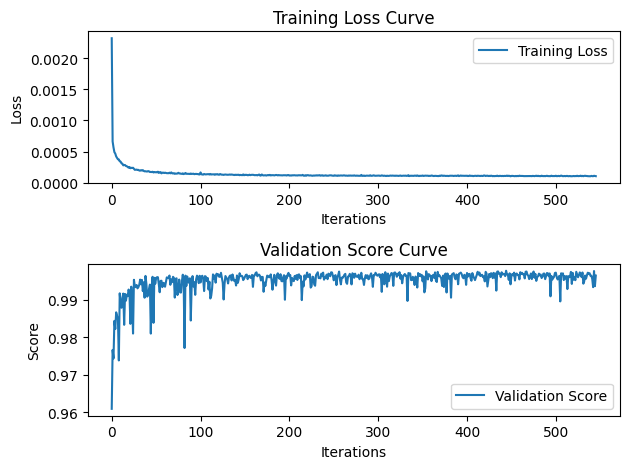

In [11]:
fig, (ax1, ax2) = plt.subplots(2, 1)

# Plotting the training loss
ax1.plot(range(mlp.n_iter_), mlp.loss_curve_, label='Training Loss')
ax1.set_xlabel('Iterations')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss Curve')
ax1.legend()

# Plotting the validation score
ax2.plot(range(mlp.n_iter_), mlp.validation_scores_, label='Validation Score')
ax2.set_xlabel('Iterations')
ax2.set_ylabel('Score')
ax2.set_title('Validation Score Curve')
ax2.legend()

plt.tight_layout()
fig.show()

In [21]:
df_y = predict(df_x_test)
df_loss = (abs(np.log10(df_y) - np.log10(df_y_test))/np.log10(df_y_test))*100
df_loss.columns = ['energy high loss', 'energy low loss'] 
df_y.columns = ['energy high pred', 'energy low pred'] 
df_comb = pd.concat([np.log10(df_y_test), np.log10(df_y), df_loss], axis=1)
df_loss.describe()

energy high loss  energy low loss
count       4813.000000      4813.000000
mean          -9.114671       -12.066731
std            7.987234        10.346792
min          -52.630534       -83.744187
25%          -12.727443       -17.363559
50%           -7.158799        -9.499918
75%           -2.861192        -4.014949
max           -0.000459        -0.006559

In [22]:
# error in percent
df_y = predict(df_x_train)
df_loss = (abs(df_y - df_y_train)/df_y_train)*100
# df_loss.sort_values(by='energy_high')
df_loss.describe()

energy_high    energy_low
count  19393.000000  19393.000000
mean       4.097018      4.383243
std        5.591227      6.339619
min        0.000129      0.000230
25%        1.287127      1.369552
50%        2.742912      2.969491
75%        5.069469      5.473085
max      191.503801    293.871304

In [14]:
df_y.sort_values(by='energy_high')

energy_high    energy_low
11360  1.264674e-08  2.056223e-07
10056  1.389887e-08  5.631497e-07
8578   1.405354e-08  4.968544e-07
7793   1.441143e-08  1.836676e-07
11946  1.477577e-08  3.544006e-06
...             ...           ...
11588  3.639255e-04  2.264146e-04
5155   3.644108e-04  1.677069e-04
7335   3.905933e-04  1.797643e-04
16781  3.908347e-04  1.794217e-04
7896   4.067316e-04  2.218450e-04

[19393 rows x 2 columns]

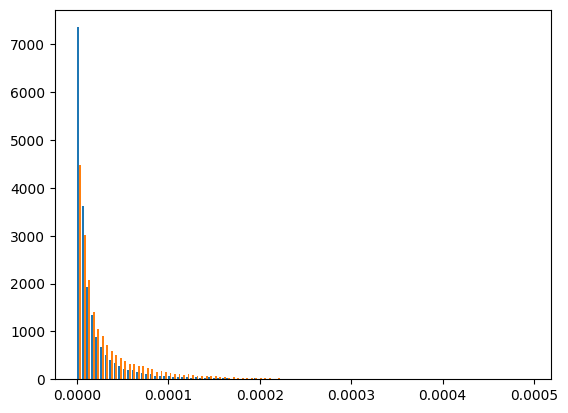

In [15]:
plt.hist(df_y_train, bins=100)
plt.show()

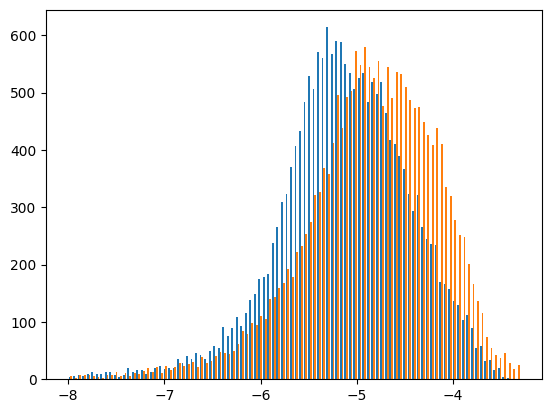

In [16]:
# better partion of the trainig data (more like gaussian curve)
plt.hist(np.log10(df_y_train), bins=100)
plt.show()

In [17]:
df_y_train.sort_values(by='energy_low')

energy_high    energy_low
17468     0.000004  1.002224e-08
13680     0.000003  1.035701e-08
19380     0.000002  1.041162e-08
11559     0.000004  1.083732e-08
15202     0.000006  1.096246e-08
...            ...           ...
1390      0.000023  4.866009e-04
11207     0.000043  4.872857e-04
7458      0.000056  4.912254e-04
11073     0.000032  4.924944e-04
5839      0.000078  4.942997e-04

[19393 rows x 2 columns]

In [18]:
df_loss.describe()

energy_high    energy_low
count  19393.000000  19393.000000
mean       4.097018      4.383243
std        5.591227      6.339619
min        0.000129      0.000230
25%        1.287127      1.369552
50%        2.742912      2.969491
75%        5.069469      5.473085
max      191.503801    293.871304

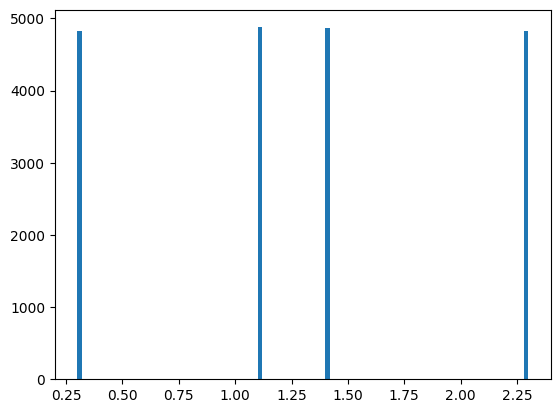

In [19]:
# 'C_ISS', 'C_OSS', 'C_RSS', 'I_DSS', 'Q_G', 'Q_GD', 'Q_GS', 'R_DS_on', 'R_G',

# plt.hist(np.log10(df_x_train[['R_G']]), bins=100)
plt.hist(df_x_train[['R_G']], bins=100)
plt.show()